### Import packages

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pickle

### Data exploration

In [26]:
df_news = pd.read_csv('news.csv')
df_news

,Unnamed: 0,date,category,text
0,0,2016-01-04 05:30:00.000000,Wirtschaft,Der Kampf gegen die Steuerflucht steht 2016 im...
1,1,2015-07-02 07:08:55.000000,Wirtschaft,Der Volltext dieses auf Agenturmeldungen basie...
2,2,2016-05-07 11:00:00.000000,Web,"Das Experiment beginnt Freitagabend, am Wochen..."
3,3,2016-05-23 09:41:27.000000,Web,"""Was waren die schlimmsten Erlebnisse, die ihr..."
4,4,2015-06-05 12:55:37.000000,Wirtschaft,Wien – Seitdem die Internationale Agentur für ...
...,...,...,...,...
5482,5482,2015-12-15 15:49:23.000000,Wissenschaft,Baikonur/London – Am frühen Dienstagabend erre...
5483,5483,2016-02-17 22:59:03.000000,Sport,Rio de Janeiro – Das Achtelfinal-Match von Dom...
5484,5484,2015-10-29 11:18:47.000000,Web,Bezahlsender Sky bringt Apps für seine hochwer...
5485,5485,2016-03-15 14:50:24.000000,Sport,Neuchatel – Nach einer neuen Studie im Auftrag...


In [27]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5487 entries, 0 to 5486
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5487 non-null   int64 
 1   date        5487 non-null   object
 2   category    5487 non-null   object
 3   text        5481 non-null   object
dtypes: int64(1), object(3)
memory usage: 171.6+ KB


In [29]:
df_news.text.isnull().sum()

6

In [31]:
# drop NaN text
df_news.dropna(inplace=True)
df_news.text.isnull().sum()

0

In [32]:
df_news.category.unique()

array(['Wirtschaft', 'Web', 'Kultur', 'Gesundheit', 'Sport',
       'Wissenschaft'], dtype=object)

#### Category distribution
we have an unbalanced dataset (see bar chart below), some solutions:

* collect more data 
* downsampling or upsampling technique (text generation)

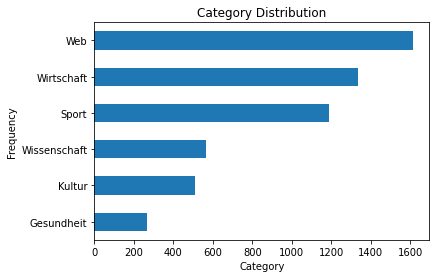

In [33]:
#category_count = pd.value_counts(df_news.category, sort=True)
df_news.category.value_counts().sort_values().plot(kind = 'barh')
#category_count.plot(kind='bar')

plt.title("Category Distribution")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [34]:
df_news[df_news.category == 'Wirtschaft'].count()

Unnamed: 0    1335
date          1335
category      1335
text          1335
dtype: int64

### Data Preprocessing
Split data into inputs and target

In [94]:
pd.options.display.max_colwidth = 400
inputs = df_news[['text']]
inputs.head()

,text
0,"Der Kampf gegen die Steuerflucht steht 2016 im Mittelpunkt der Regierungspolitik. Dies versprach Italiens Staatspräsident Sergio Mattarella bei seiner Neujahrsansprache. Und begründete das Vorhaben damit, dass 2015 dem Fiskus 122 Milliarden Euro an Steuereinnahmen verlorengingen. Das entspricht 7,5 Prozent des Bruttoinlandprodukts (BIP). Könnte man die Steuerflucht halbieren, würden 300.000 Ar..."
1,Der Volltext dieses auf Agenturmeldungen basierenden Artikels steht aus rechtlichen Gründen nicht mehr zur Verfügung.
2,"Das Experiment beginnt Freitagabend, am Wochenende der Bundespräsidentenwahl. Einmal noch schnell ein Blick auf Twitter und Facebook, dann wird der Datenzugang am Smartphone komplett abgedreht. Um auch beim Blick auf die Uhrzeit nicht in Versuchung geführt zu werden. Die erste Herausforderung kommt bei einem Konzert. Wanda spielen in der Stadthalle. Die Fotos nicht sofort mit der Welt bzw. Fre..."
3,"""Was waren die schlimmsten Erlebnisse, die ihr als IT-Mitarbeiter erlebt habt?"" Diese einfache Frage hat auf Reddit zu einer Myriade von Anekdoten geführt. Die Webseite ""Knowable"" hat sich nun die absurdesten Fälle herausgesucht und in einem Artikel zusammengefasst – der zeigt, wie weit verbreitet manche extreme Formen von ""IT-Analphabetismus"" tatsächlich sind. So erzählt ein Nutzer, dass ein ..."
4,"Wien – Seitdem die Internationale Agentur für Krebsforschung der WHO (Weltgesundheitsorganisation) im April eine neue Studie vorgestellt hat, ist in Sachen Unkrautvernichtungsmittel Feuer am Dach. Glyphosat, das weltweit am häufigsten eingesetzte Pestizid, wird darin als ""wahrscheinlich krebserregend"" eingestuft. Diejenigen Personen, die mit dem Pestizid in Berührung kommen, haben ein erh..."


In [95]:
inputs.iloc[4]

text    Wien – Seitdem die Internationale Agentur für Krebsforschung der WHO  (Weltgesundheitsorganisation) im April eine neue Studie vorgestellt hat,  ist in Sachen Unkrautvernichtungsmittel Feuer am Dach. Glyphosat, das  weltweit am häufigsten eingesetzte Pestizid, wird darin als  "wahrscheinlich krebserregend" eingestuft. Diejenigen Personen, die mit  dem Pestizid in Berührung kommen, haben ein erh...
Name: 4, dtype: object

#### clean the text data
* lowercase
* ponctuation
* numbers
* special characters
* (maybe, stop words also)

We will make the assumption that these characters are not useful for the text classfication task 

In [96]:
import re # use regular expression
import string

def clean_text(text):
    text = text.lower() # lowercase 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # ponctuation
    text = re.sub('\d', '', text) # numbers
    text = re.sub('[''–’-“”_]', '', text) # special character
    text = re.sub('\n', '', text) # new line
    return text

inputs_clean = pd.DataFrame(
            inputs.text.apply(lambda x: clean_text(x))
)

In [97]:
inputs_clean.head()

,text
0,der kampf gegen die steuerflucht steht im mittelpunkt der regierungspolitik dies versprach italiens staatspräsident sergio mattarella bei seiner neujahrsansprache und begründete das vorhaben damit dass dem fiskus milliarden euro an steuereinnahmen verlorengingen das entspricht prozent des bruttoinlandprodukts bip könnte man die steuerflucht halbieren würden arbeitsplätze mehr geschaffen w...
1,der volltext dieses auf agenturmeldungen basierenden artikels steht aus rechtlichen gründen nicht mehr zur verfügung
2,das experiment beginnt freitagabend am wochenende der bundespräsidentenwahl einmal noch schnell ein blick auf twitter und facebook dann wird der datenzugang am smartphone komplett abgedreht um auch beim blick auf die uhrzeit nicht in versuchung geführt zu werden die erste herausforderung kommt bei einem konzert wanda spielen in der stadthalle die fotos nicht sofort mit der welt bzw freunden un...
3,was waren die schlimmsten erlebnisse die ihr als itmitarbeiter erlebt habt diese einfache frage hat auf reddit zu einer myriade von anekdoten geführt die webseite knowable hat sich nun die absurdesten fälle herausgesucht und in einem artikel zusammengefasst der zeigt wie weit verbreitet manche extreme formen von itanalphabetismus tatsächlich sind so erzählt ein nutzer dass ein kollege ihm von...
4,wien seitdem die internationale agentur für krebsforschung der who weltgesundheitsorganisation im april eine neue studie vorgestellt hat ist in sachen unkrautvernichtungsmittel feuer am dach glyphosat das weltweit am häufigsten eingesetzte pestizid wird darin als wahrscheinlich krebserregend eingestuft diejenigen personen die mit dem pestizid in berührung kommen haben ein erhöhtes risiko...


#### transform target data (one hot encoding)

In [53]:
target = np.array(df_news['category'].values)
print(target.shape)
print(target[:10])

(5481,)
['Wirtschaft' 'Wirtschaft' 'Web' 'Web' 'Wirtschaft' 'Kultur' 'Gesundheit'
 'Sport' 'Sport' 'Sport']


In [180]:
i = 0
target_dict = {}
for category in df_news.category.unique():
    target_dict[category] = i
    i+=1
print(target_dict)

# one hot encoding
target_enc = np.zeros((len(target), len(np.unique(target))), dtype='int')
for i, category in enumerate(target):
    target_enc[i, target_dict[category]] = 1
print(target_enc.shape)
print(target_enc[:10])

{'Wirtschaft': 0, 'Web': 1, 'Kultur': 2, 'Gesundheit': 3, 'Sport': 4, 'Wissenschaft': 5}
(5481, 6)
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


#### Word Indexing
use the TextVectorization form Keras to index the vocabulary found in the dataset.

In [230]:
text_array = np.array(inputs_clean.values) 
print(text_array.shape)
print(text_array[1])

(5481, 1)
['der volltext dieses auf agenturmeldungen basierenden artikels steht aus rechtlichen gründen nicht mehr zur verfügung']


consider the top 20,000 words. Truncate or pad sequences to be actually 200 tokens long.

In [231]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(text_array)

In [232]:
# top words - too many die, der, und
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'die', 'der', 'und']

In [233]:
output = vectorizer([["Ich beschäftige mich mit data science"]])
output.numpy()[0, :6]

array([   54, 16020,   231,     9,  4702,  1766])

#### remove stop words: die, der, und etc.

In [298]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

stop = set(stopwords.words('german'))
def remove_stop_words(data):
    for i, sentence in enumerate(data):
        sentence_without_stops = [i for i in word_tokenize(sentence[0].lower()) 
                                  if i not in stop]
        sent = [TreebankWordDetokenizer().detokenize(sentence_without_stops)]
        data[i] = sent
    return data

In [299]:
text_array = remove_stop_words(text_array)
print(text_array[1])

['volltext agenturmeldungen basierenden artikels steht rechtlichen gründen mehr verfügung']


In [300]:
# index without stop words
max_tokens = 20000
output_sequence_length = 500
vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=output_sequence_length)
vectorizer.adapt(text_array)

In [301]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'mehr', 'prozent', 'wurde']

In [302]:
output = vectorizer([["liebe data science"]])
output.numpy()[0, :6]

array([ 986, 4509, 1587,    0,    0,    0])

In [303]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [304]:
test = ["liebe", "data", "science"]
[word_index[w] for w in test] 

[986, 4509, 1587]

#### create train, validation and test set

In [305]:
train_X, test_X, train_Y, test_Y = train_test_split(text_array, target_enc,
                                                   test_size=0.1)
X, val_X, Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1)
print("X shape : {}, Y shape: {}".format(X.shape, Y.shape))
print("val_X shape : {}, val_Y shape: {}".format(val_X.shape, val_Y.shape))
print("test_X shape : {}, test_Y shape: {}".format(test_X.shape, test_Y.shape))

X shape : (4438, 1), Y shape: (4438, 6)
val_X shape : (494, 1), val_Y shape: (494, 6)
test_X shape : (549, 1), test_Y shape: (549, 6)


### Build the model

In [321]:
from tensorflow.keras import layers, Input

embedding_dim = 200

input_int = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = layers.Embedding(max_tokens, embedding_dim)(input_int)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(df_news.category.unique()),
                       activation="softmax")(x)
model = keras.Model(input_int, outputs)
model.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_20 (Embedding)     (None, None, 200)         4000000   
_________________________________________________________________
conv1d_52 (Conv1D)           (None, None, 128)         128128    
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, None, 128)       

In [322]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [315]:
X.shape

(4438, 1)

In [316]:
x_train = vectorizer(X).numpy()
x_val = vectorizer(val_X).numpy()
x_test = vectorizer(test_X).numpy()

y_train = np.array(Y)
y_val = np.array(val_Y)
y_test = np.array(test_Y)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(4438, 500)
(494, 500)
(549, 500)


In [317]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4438, 500) (4438, 6)
(494, 500) (494, 6)


In [318]:
print(x_train[2])

[  127  9562 10320     1 11197   221    38     1   151 13557  1774  3188
  2708     1 10253  3018 16050    41    41   731 19941   153  1128  3098
    19   516  8162     1     1  1795  7168   108  1774   822  9562  2480
   228  1076   533    41    41   731 19941  1076  2078  2959 14306   994
  1441   442     1  1352  3643 15193     1 19562   404   221   727   668
     1  2818  2251 18059     1 10449 10320  1640 10253   404   221   383
   108  4290   517   263  2902   734  2818  1291 14088  4999  7871 19942
    41    41   731  2536  2034     1  2839     1  2034     1 11263   565
    38 14368  1781  3098  1774  4659    28     6   944  7716     1   242
  9224     6   108  2762  1547   447   108   364   408   727     1    11
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

### Train the model
I think, I have an error in the dimensions, I couldn't fix due to lack of time

In [323]:
history = model.fit(x_train, y_train, 
          batch_size=128, epochs=10,
          validation_data=(x_val, y_val))

Epoch 1/10
35/35 [==============================] - 31s 886ms/step - loss: 0.4235 - accuracy: 0.2652 - val_loss: 0.3942 - val_accuracy: 0.3077
Epoch 2/10
35/35 [==============================] - 30s 871ms/step - loss: 0.3202 - accuracy: 0.4603 - val_loss: 0.1982 - val_accuracy: 0.7004
Epoch 3/10
35/35 [==============================] - 29s 831ms/step - loss: 0.1496 - accuracy: 0.7877 - val_loss: 0.1702 - val_accuracy: 0.7996
Epoch 4/10
35/35 [==============================] - 34s 964ms/step - loss: 0.0888 - accuracy: 0.8806 - val_loss: 0.1556 - val_accuracy: 0.8259
Epoch 5/10
35/35 [==============================] - 29s 819ms/step - loss: 0.0555 - accuracy: 0.9338 - val_loss: 0.1586 - val_accuracy: 0.8300
Epoch 6/10
35/35 [==============================] - 37s 1s/step - loss: 0.0379 - accuracy: 0.9615 - val_loss: 0.1835 - val_accuracy: 0.8239
Epoch 7/10
35/35 [==============================] - 33s 932ms/step - loss: 0.0246 - accuracy: 0.9770 - val_loss: 0.2087 - val_accuracy: 0.8279
Ep

### Prediction
Overfitting problem --> should the model with less epochs

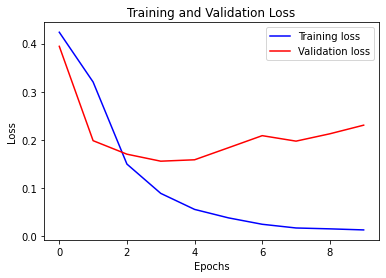

In [324]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

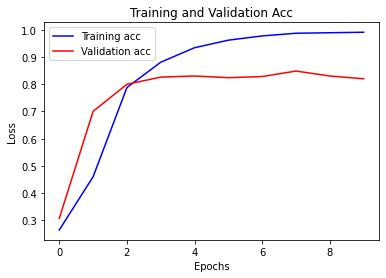

In [326]:
def visualize_acc(history, title):
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training acc")
    plt.plot(epochs, val_loss, "r", label="Validation acc")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_acc(history, "Training and Validation Acc")

In [332]:
predictions = model.predict(x_test)
pred = np.argmax(predictions, axis=1)
true = np.argmax(y_test, axis=1)
print("accuracy test set : ", (pred == true).sum() / len(true))

accuracy test set :  0.8579234972677595


In [350]:
text = np.array(["dieser Text ist über Geld und Wirtschaft", "die Korona hat unsere Gesundheit verschlechert",
                 "Menschen sterben heutzutage jeden Tag", "Real Madrid hat das Champions League wieder gewonnen",
                 "Politiker sind nicht gut", "Bewerbungen für Data Science Stellen sind nicht viele"])
text.shape

(6,)

In [351]:
text = text.tolist()
text = np.array([clean_text(x) for x in text])
text = remove_stop_words(text.reshape(-1, 1))
text

array([['text geld wirtschaft'],
       ['korona gesundheit verschlechert'],
       ['menschen sterben heutzutage tag'],
       ['real madrid champions league gewonnen'],
       ['politiker gut'],
       ['bewerbungen data science stellen viele']], dtype='<U53')

In [352]:
text_vec = vectorizer(text).numpy()

In [353]:
text_vec.shape

(6, 500)

In [354]:
one_hot_to_label_dict = {}
for key, value in target_dict.items():
    one_hot_to_label_dict[value] = key

In [357]:
predi = model.predict(text_vec)
print(predi.shape)
pred_index = np.argmax(predi, axis=1)
for elem in pred_index:
    print(one_hot_to_label_dict[elem])

(6, 6)
Wirtschaft
Gesundheit
Gesundheit
Sport
Wissenschaft
Wissenschaft
